### Setup

In [1]:
import matplotlib.pyplot as plt
import torch

from src.data.celeba import CelebADataModule
from src.models.components.tokenizer import Tokenizer
from src.utils.patch import depatchify, patchify

### Dataset

In [2]:
def show_images(images, title, n_images=4):
    """Display a grid of images."""
    fig, axes = plt.subplots(1, n_images, figsize=(15, 4))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0)  # CHW -> HWC
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle(title)
    plt.show()


def show_patches(patches, title, n_images=4, patch_size=8):
    """Display a grid of patches from the first image."""
    n_patches = patches.shape[1]
    n_cols = int(n_patches**0.5)
    n_rows = n_patches // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < n_patches:
            patch = patches[0, i].reshape(3, patch_size, patch_size)
            patch = patch.permute(1, 2, 0)  # CHW -> HWC
            # Normalize to [0, 1]
            patch = (patch - patch.min()) / (patch.max() - patch.min())
            ax.imshow(patch)
        ax.axis("off")

    plt.suptitle(title)
    plt.show()

In [3]:
data_module = CelebADataModule(data_dir="./data", image_size=64, batch_size=4, num_workers=0)
data_module.prepare_data()
data_module.setup()
dataset = data_module.train_dataloader().dataset

Original images shape: torch.Size([4, 3, 64, 64])


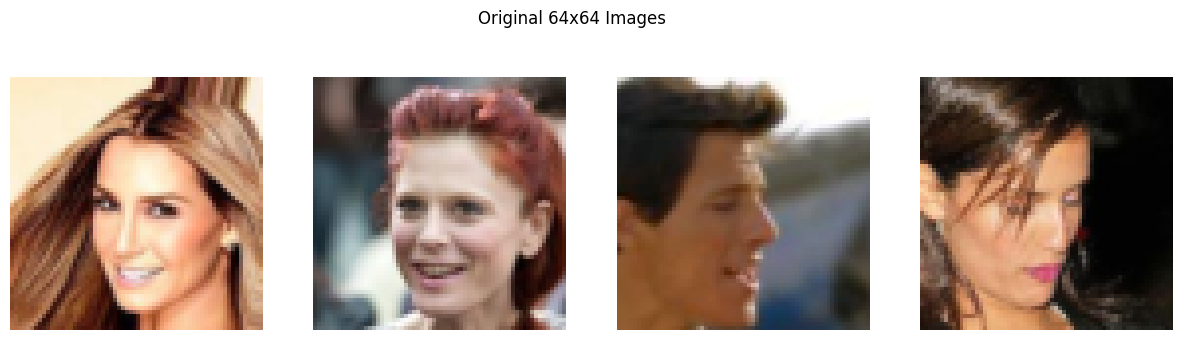

In [4]:
# Get a batch of images
batch_size = 4
images = torch.stack([dataset[i][0] for i in range(batch_size)])
print(f"Original images shape: {images.shape}")

# Should be (4, 3, 64, 64)
show_images(images, "Original 64x64 Images")

### Patching

Patches shape: torch.Size([4, 64, 192])


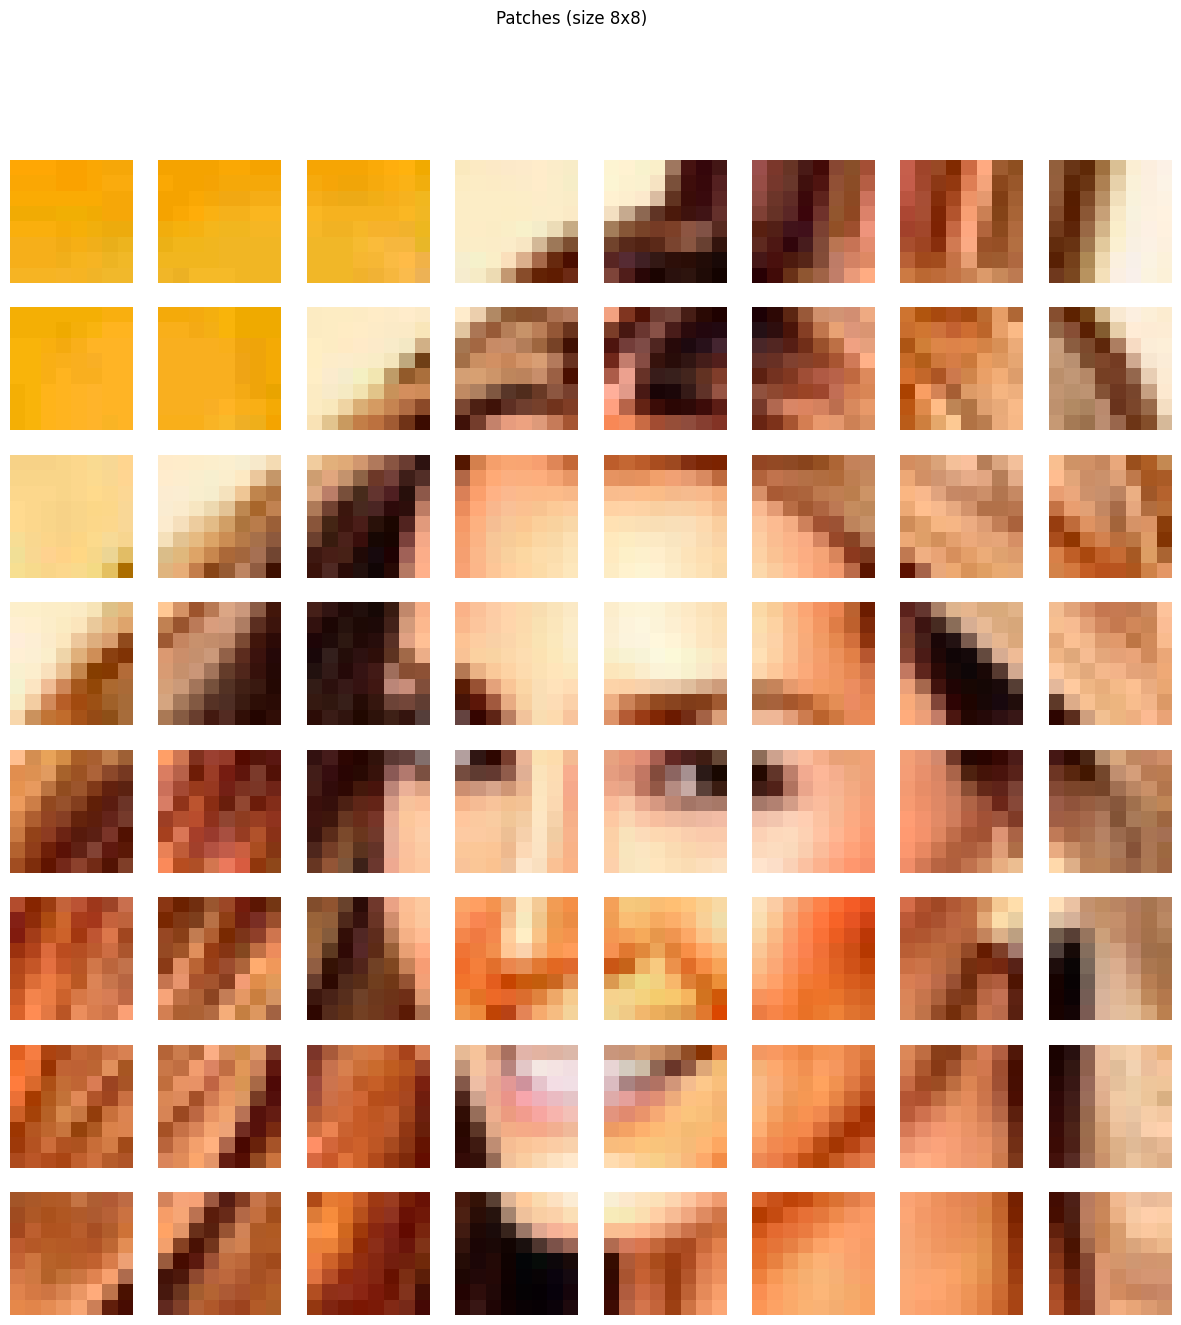

In [5]:
# Split into patches
patch_size = 8
patches = patchify(images, patch_size)

# Should be (4, 64, 192) for (batch_size, n_patches, (patch_size * patch_size) * 3 channels)
print(f"Patches shape: {patches.shape}")

# Show patches from first image
show_patches(patches, f"Patches (size {patch_size}x{patch_size})", patch_size=patch_size)

### Depatching

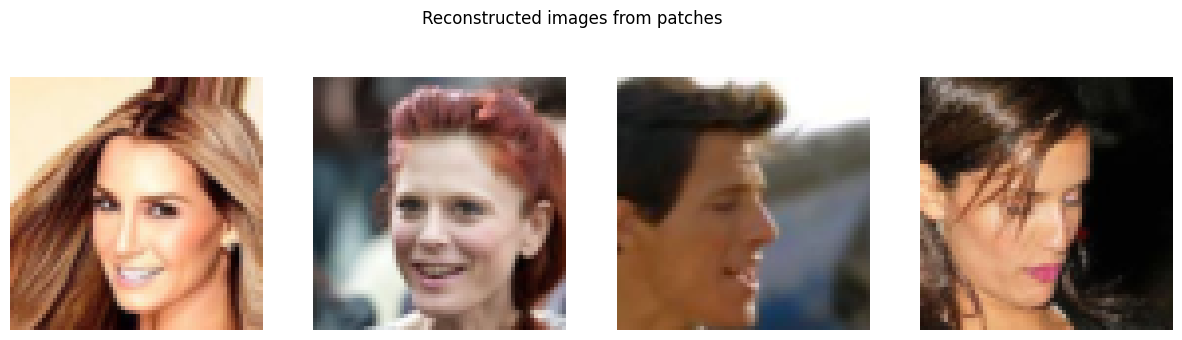

In [6]:
# Reshape patches back to image format for visualization
reconstructed = depatchify(patches, patch_size, 64)
show_images(reconstructed, "Reconstructed images from patches")

### Tokenizing

In [7]:
def show_token_embeddings(tokens, title, n_tokens=4):
    """Display token embeddings as heatmaps."""
    fig, axes = plt.subplots(1, n_tokens, figsize=(15, 4))
    for i, ax in enumerate(axes):
        # Take first image's tokens
        token = tokens[0, i].reshape(16, 16)
        im = ax.imshow(token.detach().cpu().numpy(), cmap="viridis")

        # Label each token
        ax.axis("off")
        ax.set_title(f"Token {i}")

    plt.colorbar(im, ax=axes.ravel().tolist())
    plt.suptitle(title)
    plt.show()

Tokenized shape: torch.Size([4, 64, 256])


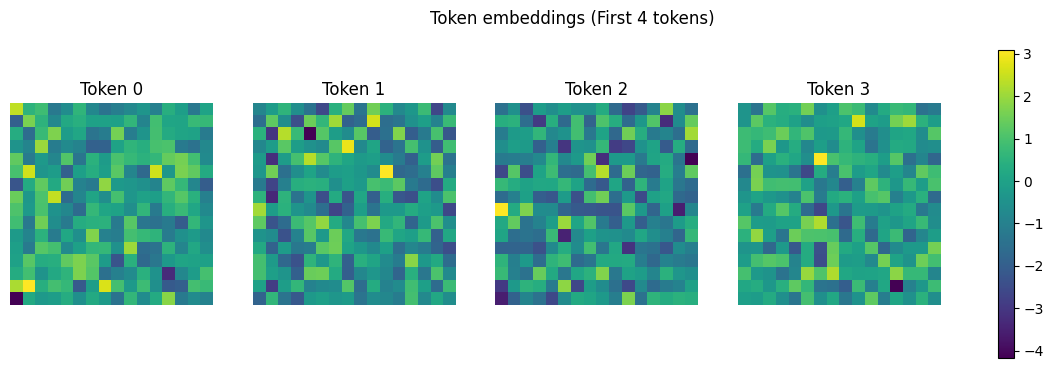

In [8]:
# Test tokenizer
tokenizer = Tokenizer(patch_size=patch_size, dim=256, image_size=64)
tokens = tokenizer(images)

# Should be (4, 64, 256) for (batch_size, n_patches, dim)
print(f"Tokenized shape: {tokens.shape}")

# Show token embeddings for first few tokens of first image
show_token_embeddings(tokens, "Token embeddings (First 4 tokens)")